### Task 1 : Ready


In [59]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
%matplotlib inline

train_df = pd.read_csv('C:/Users/ewfem/Desktop/糖尿病遗传风险检测挑战赛/比赛训练集.csv', encoding='gbk')
test_df = pd.read_csv('C:/Users/ewfem/Desktop/糖尿病遗传风险检测挑战赛/比赛测试集.csv', encoding='gbk')

print(train_df.shape, test_df.shape)
print(train_df.dtypes, test_df.dtypes)

(5070, 10) (1000, 9)
编号            int64
性别            int64
出生年份          int64
体重指数        float64
糖尿病家族史       object
舒张压         float64
口服耐糖量测试     float64
胰岛素释放实验     float64
肱三头肌皮褶厚度    float64
患有糖尿病标识       int64
dtype: object 编号            int64
性别            int64
出生年份          int64
体重指数        float64
糖尿病家族史       object
舒张压         float64
口服耐糖量测试     float64
胰岛素释放实验     float64
肱三头肌皮褶厚度    float64
dtype: object


### Task 2 : Data Analysis
*步骤1：统计字段的缺失值，计算缺失比例*
* *训练集和测试机缺失数据分布一致，舒张压缺失一半数据*

In [60]:
print(train_df.isnull().mean(0))
print(60*'-')
print(test_df.isnull().mean(0))

编号          0.000000
性别          0.000000
出生年份        0.000000
体重指数        0.000000
糖尿病家族史      0.000000
舒张压         0.048718
口服耐糖量测试     0.000000
胰岛素释放实验     0.000000
肱三头肌皮褶厚度    0.000000
患有糖尿病标识     0.000000
dtype: float64
------------------------------------------------------------
编号          0.000
性别          0.000
出生年份        0.000
体重指数        0.000
糖尿病家族史      0.000
舒张压         0.049
口服耐糖量测试     0.000
胰岛素释放实验     0.000
肱三头肌皮褶厚度    0.000
dtype: float64


In [61]:
train_df['舒张压'].value_counts().sort_values(ascending=False)

86.0     339
85.0     312
84.0     311
88.0     308
87.0     303
89.0     299
83.0     258
97.0     222
96.0     220
93.0     218
94.0     213
95.0     211
99.0     206
91.0     199
90.0     198
98.0     193
76.0      47
106.0     44
108.0     39
109.0     39
101.0     38
68.0      36
80.0      35
66.0      34
72.0      34
70.0      34
107.0     34
74.0      32
78.0      30
62.0      30
102.0     30
103.0     30
100.0     29
104.0     29
110.0     28
82.0      28
105.0     25
60.0      19
64.0      17
58.0      14
54.0       9
50.0       8
56.0       6
73.0       5
48.0       4
52.0       4
112.0      3
46.0       3
71.0       3
44.0       3
63.0       2
126.0      1
114.0      1
30.0       1
59.0       1
116.0      1
69.0       1
34.0       1
120.0      1
Name: 舒张压, dtype: int64

*步骤2：分析字段类型*
* *9个数值型，1个类别型；但是从分析角度，存在3个类别型，分别是性别、糖尿病家族史、患有糖尿病标识，这里只是用数字代替类别*

In [62]:
train_df.head(2)

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
0,1,0,1996,30.1,无记录,106.0,3.818,7.89,0.0,0
1,2,0,1988,27.5,无记录,84.0,-1.000,0.00,14.7,0


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070 entries, 0 to 5069
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   编号        5070 non-null   int64  
 1   性别        5070 non-null   int64  
 2   出生年份      5070 non-null   int64  
 3   体重指数      5070 non-null   float64
 4   糖尿病家族史    5070 non-null   object 
 5   舒张压       4823 non-null   float64
 6   口服耐糖量测试   5070 non-null   float64
 7   胰岛素释放实验   5070 non-null   float64
 8   肱三头肌皮褶厚度  5070 non-null   float64
 9   患有糖尿病标识   5070 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 396.2+ KB


*步骤3：计算字段相关性*
* *数据相关性不强，符合独立同分布*

In [64]:
train_df['糖尿病家族史'].value_counts()

无记录               2897
叔叔或姑姑有一方患有糖尿病     1084
父母有一方患有糖尿病         875
叔叔或者姑姑有一方患有糖尿病     214
Name: 糖尿病家族史, dtype: int64

In [65]:
# 编码中文字符
train_df['糖尿病家族史'] = train_df['糖尿病家族史'].map({
    '无记录':0, 
    '叔叔或姑姑有一方患有糖尿病':1, 
    '父母有一方患有糖尿病':2,
    '叔叔或者姑姑有一方患有糖尿病':1,
})

test_df['糖尿病家族史'] = test_df['糖尿病家族史'].map({
    '无记录':0, 
    '叔叔或姑姑有一方患有糖尿病':1, 
    '父母有一方患有糖尿病':2,
    '叔叔或者姑姑有一方患有糖尿病':1,
})

In [66]:
train_df.drop(['编号'], axis=1).corr()

,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
性别,1.000000,-0.119563,0.075186,-0.000694,0.078870,0.011463,-0.053597,0.014037,0.031480
出生年份,-0.119563,1.000000,-0.074603,0.035728,-0.154631,0.002085,0.058585,-0.013111,-0.068225
体重指数,0.075186,-0.074603,1.000000,-0.041778,0.159903,-0.001796,-0.034507,0.026321,0.377919
糖尿病家族史,-0.000694,0.035728,-0.041778,1.000000,-0.160515,0.042249,0.119965,-0.030645,0.005897
舒张压,0.078870,-0.154631,0.159903,-0.160515,1.000000,-0.020317,-0.206663,0.076147,0.157421
口服耐糖量测试,0.011463,0.002085,-0.001796,0.042249,-0.020317,1.000000,0.093715,-0.006483,0.178133
胰岛素释放实验,-0.053597,0.058585,-0.034507,0.119965,-0.206663,0.093715,1.000000,-0.015479,0.156656
肱三头肌皮褶厚度,0.014037,-0.013111,0.026321,-0.030645,0.076147,-0.006483,-0.015479,1.000000,0.410667
患有糖尿病标识,0.031480,-0.068225,0.377919,0.005897,0.157421,0.178133,0.156656,0.410667,1.000000


d:\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


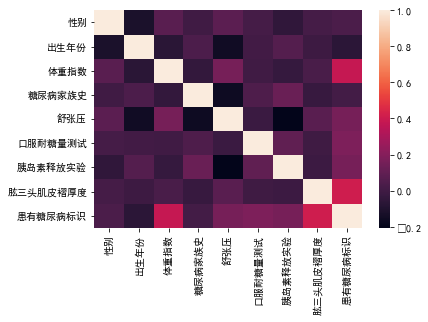

In [67]:
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.heatmap(train_df.drop(['编号'], axis=1).corr())

### Task 3：逻辑回归尝试
*步骤1：导入模块*

In [68]:
from sklearn.linear_model import LogisticRegression

*步骤2：使用训练集和逻辑回归进行训练，并在测试集上进行预测*

In [69]:
# 填充缺失值
train_df['舒张压'].fillna(train_df['舒张压'].mean(), inplace=True)
test_df['舒张压'].fillna(test_df['舒张压'].mean(), inplace=True)

# 拟合训练集
X = train_df.drop(['编号', '患有糖尿病标识'], axis=1)
y = train_df['患有糖尿病标识']
model_lr = LogisticRegression()
model_lr.fit(X,y)

# 预测
test_df['label'] = model_lr.predict(test_df.drop(['编号'], axis=1))
test_df.rename({'编号': 'ID'}, axis=1)[['ID','label']].to_csv('C:/Users/ewfem/Desktop/糖尿病遗传风险检测挑战赛/submit1.csv', index=None)

d:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


![](https://raw.githubusercontent.com/EWFEMLTY-D/Picbed/main/微信图片_20220629151151.png)

*步骤4：将训练集20%划分为验证集，在训练部分进行训练，在测试部分进行预测，调节逻辑回归的超参数*

In [70]:
from sklearn.model_selection import GridSearchCV

def get_best_model(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0.)
    grid.fit(X, y)
    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['编号','患有糖尿病标识'], axis=1), train_df['患有糖尿病标识'], test_size=0.2, random_state=2022)
Ir_params = {'C':[0.1,1,5,10,50,100],'penalty':['l1','l2'],'solver':['liblinear','saga']}
model_lr_1 = LogisticRegression()
get_best_model(model_lr_1, Ir_params, X_train, y_train)

d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\A

Best Accuracy: 0.813855363141047
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [72]:
model_lr_2 = LogisticRegression(C=0.1, penalty='l1', solver='saga')
model_lr_2.fit(X_train, y_train)
y_pred = model_lr_2.predict(X_test)
print(f1_score(y_test, y_pred))

0.7830985915492956


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [73]:
test_df.head(2)

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,label
0,1,0,1987,33.1,0,72.0,6.586,24.16,2.94,0
1,2,0,1998,20.6,1,68.0,3.861,0.00,0.00,0


In [74]:
# 预测
test_df['label'] = model_lr_2.predict(test_df.drop(['编号','label'], axis=1))
test_df.rename({'编号': 'ID'}, axis=1)[['ID','label']].to_csv('C:/Users/ewfem/Desktop/糖尿病遗传风险检测挑战赛/submit2.csv', index=None)


![](https://raw.githubusercontent.com/EWFEMLTY-D/Picbed/main/微信图片_20220630001148.png)

![](https://raw.githubusercontent.com/EWFEMLTY-D/Picbed/微信图片_20220629151151.png)